In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
  return 3 * x**2 - 4 * x + 5

In [ ]:
f(3.0)

20.0

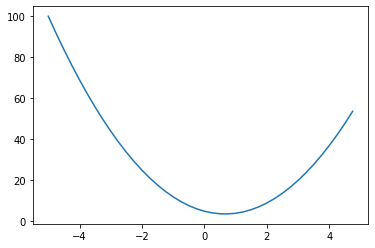

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [ ]:
h = 0.001
x = 3.0
f(x)
(f(x + h) - f(x)) / h

14.00300000000243

In [139]:
class Value:

  def __init__(self, data, _children=(), _op=''):
    self.data = data
    self.grad = 0
    self._backward = lambda: None
    self.label = ''
    self._prev = set(_children)
    self._op = _op

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __radd__(self, other):
    return self + other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __pow__(self, v):
    assert isinstance(v, (int, float))
    out = Value(self.data ** v, (self,), f"**{v}")

    def _backward():
      self.grad += v * self.data ** (v - 1) * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * (other**-1)

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __rsub__(self, other):
    return self + (-other)

  def tanh(self):
    x = self.data
    t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - out.data**2) * out.grad
    out._backward = _backward
    return out

  def relu(self):
    out = Value(0 if self.data < 0 else self.data, (self, ), 'ReLU')

    def _backward():
        self.grad += (out.data > 0) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()

    def topological_sort(x):
      if x not in visited:
        visited.add(x)
        for c in x._prev:
          topological_sort(c)
        topo.append(x)
    topological_sort(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

a = Value(2.0)
b = Value(-3.0)
c = Value(10)
d = a * b + c
d

Value(data=4.0)

In [140]:
d._prev

{Value(data=-6.0), Value(data=10)}

In [141]:
d._op

'+'

In [142]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [143]:
import random

class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

  def zero_grad(self):
    for param in self.parameters():
      param.grad = 0.0


class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    params = []
    for n in self.neurons:
      params.extend(n.parameters())
    return params

  def zero_grad(self):
    for param in self.parameters():
      param.grad = 0.0


class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

  def zero_grad(self):
    for param in self.parameters():
      param.grad = 0.0

In [144]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.9979010948758221)

In [145]:
nL = Layer(2, 3)
nL(x)

[Value(data=-0.1641906618908629),
 Value(data=-0.998263637054169),
 Value(data=-0.9994123949544672)]

In [205]:
x = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])
mlp(x)

Value(data=-0.46691432285233625)

In [206]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [207]:
def loss_func(ground_truths, predictions):
  return sum((prediction - ground_truth)**2 for ground_truth, prediction in zip(ground_truths, predictions))

In [208]:
def train_model(mlp, xs, ys, loss_func, alpha=0.001, times=20):
  for _ in range(times):
    ypred = [mlp(x) for x in xs]
    loss = loss_func(ys, ypred)

    mlp.zero_grad()
    loss.backward()

    for param in mlp.parameters():
      param.data -= alpha * param.grad
    
    print(f"Step {_}; Loss {loss}")

In [209]:
train_model(mlp, xs, ys, loss_func, 0.05, 100)

Step 0; Loss Value(data=5.520007447761283)
Step 1; Loss Value(data=3.705114094867439)
Step 2; Loss Value(data=3.318643088400393)
Step 3; Loss Value(data=3.0104829271841798)
Step 4; Loss Value(data=2.689070512619149)
Step 5; Loss Value(data=2.352358286520113)
Step 6; Loss Value(data=2.0160919153756787)
Step 7; Loss Value(data=1.6571494043794681)
Step 8; Loss Value(data=1.2681559617666691)
Step 9; Loss Value(data=0.9004133256277371)
Step 10; Loss Value(data=0.6214493552502796)
Step 11; Loss Value(data=0.4405113837719322)
Step 12; Loss Value(data=0.3269457239627043)
Step 13; Loss Value(data=0.2533381038271446)
Step 14; Loss Value(data=0.20335299657711492)
Step 15; Loss Value(data=0.16788371276913927)
Step 16; Loss Value(data=0.1417483290578212)
Step 17; Loss Value(data=0.12187377380282396)
Step 18; Loss Value(data=0.10635702187011155)
Step 19; Loss Value(data=0.09397159127466558)
Step 20; Loss Value(data=0.08389850851734276)
Step 21; Loss Value(data=0.07557365703625765)
Step 22; Loss Valu

In [212]:
print(ys)
print([mlp(x) for x in xs])

[1.0, -1.0, -1.0, 1.0]
[Value(data=0.9677308366414352), Value(data=-0.9829031953565026), Value(data=-0.9513725722387202), Value(data=0.9488746483617969)]


#Test

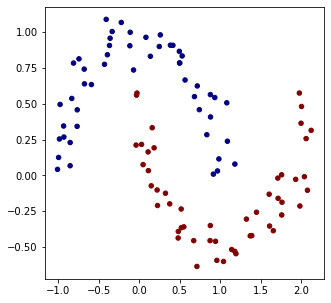

In [233]:
# make a dataset
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [238]:
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

number of parameters 337


(-1.6349545678983317, 1.8650454321016683)

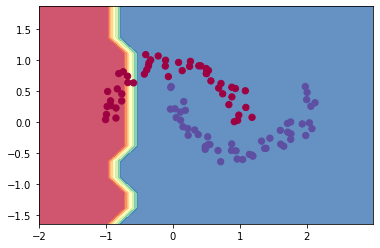

In [239]:
# visualize decision boundary before training
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [240]:
train_model(model, X, y, loss_func, 0.001, 50)

Step 0; Loss Value(data=130.41358858459103)
Step 1; Loss Value(data=89.9779291421556)
Step 2; Loss Value(data=71.78811057619937)
Step 3; Loss Value(data=62.07426940690313)
Step 4; Loss Value(data=56.331806313242474)
Step 5; Loss Value(data=50.889921520994015)
Step 6; Loss Value(data=45.34036423944538)
Step 7; Loss Value(data=40.71052689999515)
Step 8; Loss Value(data=37.517217744857234)
Step 9; Loss Value(data=35.263450006711004)
Step 10; Loss Value(data=33.65246757398384)
Step 11; Loss Value(data=32.474500389794265)
Step 12; Loss Value(data=31.542714541531467)
Step 13; Loss Value(data=30.732859207492567)
Step 14; Loss Value(data=29.980902878463443)
Step 15; Loss Value(data=29.25926208166766)
Step 16; Loss Value(data=28.55710349953165)
Step 17; Loss Value(data=27.87042711674129)
Step 18; Loss Value(data=27.198077956780452)
Step 19; Loss Value(data=26.540181819779473)
Step 20; Loss Value(data=25.89742769922178)
Step 21; Loss Value(data=25.27066444607952)
Step 22; Loss Value(data=24.6606

(-1.6349545678983317, 1.8650454321016683)

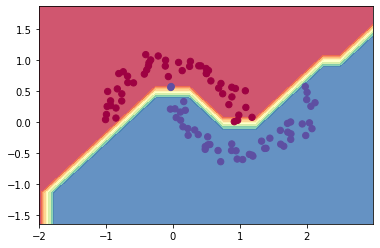

In [241]:
# visualize decision boundary before training
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())